In [1]:
# Import Libraries
from PIL import Image
import numpy as np
from numpy import linalg as la
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from itertools import cycle
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

In [2]:
Training_Images = []
Testing_Images = []

for i in range(0,180):
    filename = r'C:\Users\power\Desktop\cv-task5\AllData\TrainingImages\Face' +str(i) + '.jpg'
    im=Image.open(filename).convert('L')
    im= np.asarray(im,dtype=float)/255.0 
    Training_Images.append(im)

for i in range(0,60):
    filename =r'C:\Users\power\Desktop\cv-task5\AllData\TestingImages\Face' +str(i) + '.jpg'
    im=Image.open(filename).convert('L')
    im= np.asarray(im,dtype=float)/255.0 
    Testing_Images.append(im)

TrainImages_num = len(Training_Images)
TestImages_num = len(Testing_Images)

In [3]:
# Getting Mean and Eigen faces
flattened_images  =[]

for i in range(TrainImages_num):
    p=Training_Images[i].flatten()
    flattened_images.append(p)
A_transpose = np.matrix(flattened_images)
A = np.transpose(A_transpose)

Mean= np.mean(A,1)
b= Mean.reshape(128,128)
resized_mean=np.array(Image.fromarray(np.asarray(b)).resize((100, 100), Image.BILINEAR))

zero_mean =[]
column =0
Zero_mean_matrix= np.ones((16384,TrainImages_num))
for values in flattened_images:
    zm= A[:,column] - Mean         # zm = values - mean
    zm = np.squeeze(zm)
    Zero_mean_matrix[:,column] =zm
    zm_images = zm.reshape(128,128)
    zero_mean.append(zm)
    column = column +1

d = (np.dot(np.transpose(Zero_mean_matrix),Zero_mean_matrix))/425
u_list =[]
w2, v2 = la.eigh(d)

for ev in v2:
    ev_transpose = np.transpose(np.matrix(ev))
    u = np.dot(Zero_mean_matrix,ev_transpose)                        
    u = u / np.linalg.norm(u)
    u_i= u.reshape(128,128)
    u_list.append(u_i)

C:\Users\power\AppData\Local\Temp\ipykernel_8700\2621018173.py:12: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  resized_mean=np.array(Image.fromarray(np.asarray(b)).resize((100, 100), Image.BILINEAR))


In [4]:
dict ={}
def Reconstruct(k):
    weights=np.zeros((TrainImages_num,k))
    matrixU = np.zeros((16384,k))
    c =0
    for val in range(k-1,-1,-1):
        matrixU[:,c] = u_list[val].flatten()
        c = c+1
    rec_face=[]
    for face_num in range(0,TrainImages_num):
        w = np.dot(np.transpose(matrixU) ,Zero_mean_matrix[:,face_num])
        weights[face_num,:] =w

        face = np.dot(w, np.transpose(matrixU))
        minf = np.min(face)
        maxf = np.max(face)
        face = face-float(minf)
        face = face/float((maxf-minf))
        face = face+np.transpose(Mean)
        reshape_face = face.reshape(128,128)
        rec_face.append( reshape_face)
    dict[k] = weights

Reconstruct(180)


		k = 180
Minimum Distance :  16.73248186078469


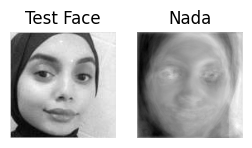

Minimum Distance :  47.91081095287503


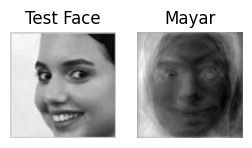

Minimum Distance :  17.22756850866927


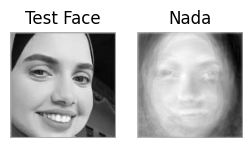

Minimum Distance :  32.035574329531805


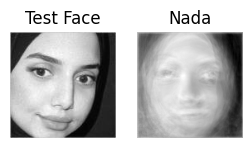

Minimum Distance :  32.9792855332086


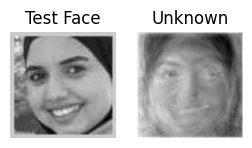

Minimum Distance :  39.35404608566187


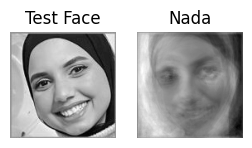

Minimum Distance :  31.109045267118674


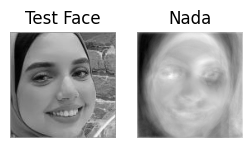

Minimum Distance :  21.743246448746806


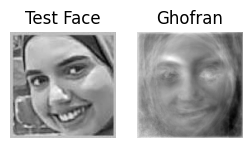

Minimum Distance :  31.14816735113636


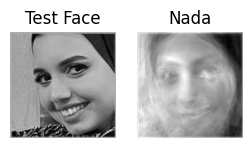

Minimum Distance :  38.899710857414625


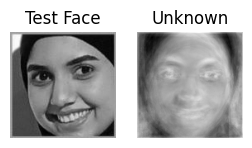

Minimum Distance :  7.941335831868515


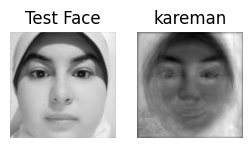

Minimum Distance :  68.80954136554129


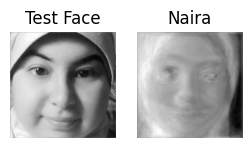

Minimum Distance :  0.0


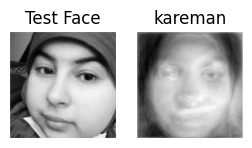

Minimum Distance :  50.80688281648675


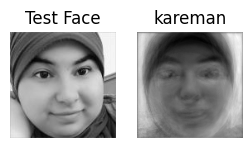

Minimum Distance :  9.088967048643957


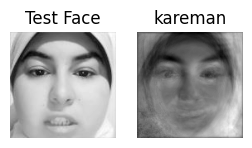

Minimum Distance :  57.64488615439265


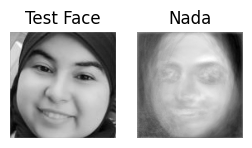

Minimum Distance :  29.939476030787286


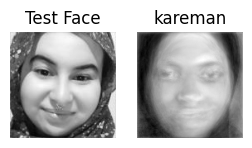

Minimum Distance :  0.0


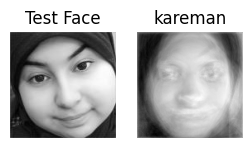

Minimum Distance :  14.442451056968569


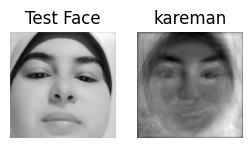

Minimum Distance :  0.0


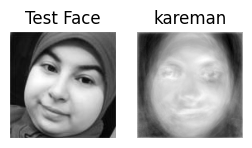

Minimum Distance :  36.333193203728705


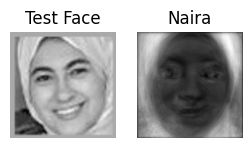

Minimum Distance :  21.111038573627393


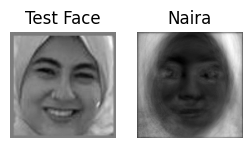

Minimum Distance :  43.80251145203818


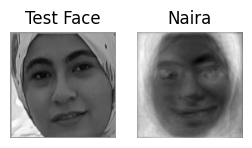

Minimum Distance :  21.436788131134577


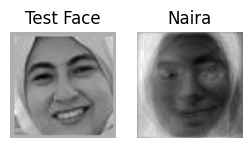

Minimum Distance :  31.713161296563488


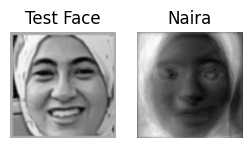

Minimum Distance :  22.043452458303676


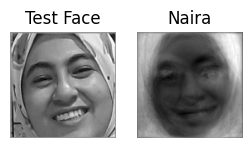

Minimum Distance :  40.3084254529883


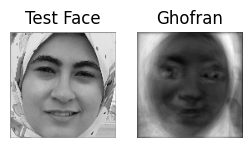

Minimum Distance :  22.86782113166716


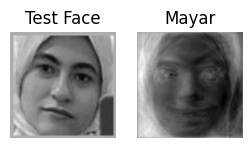

Minimum Distance :  37.392179362465484


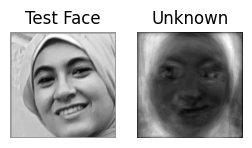

Minimum Distance :  31.616266528149843


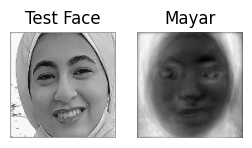

Minimum Distance :  0.010737306863285973


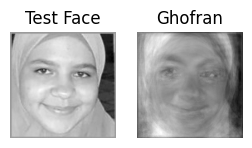

Minimum Distance :  31.909317530682298


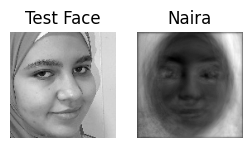

Minimum Distance :  47.98752360782021


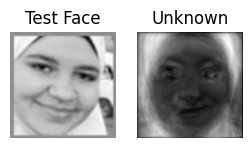

Minimum Distance :  0.030236365427667073


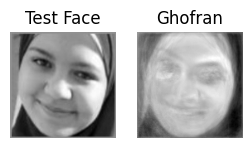

Minimum Distance :  0.012349319626990273


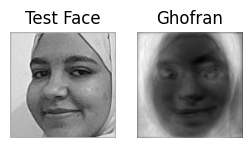

Minimum Distance :  29.855937614465127


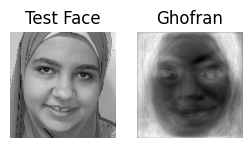

Minimum Distance :  0.054834700848624116


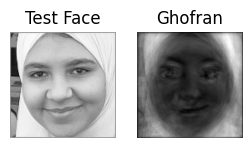

Minimum Distance :  0.010072121795066655


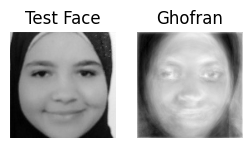

Minimum Distance :  33.03070560232618


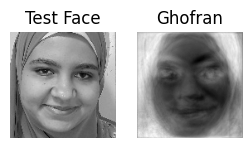

Minimum Distance :  0.018265901143615655


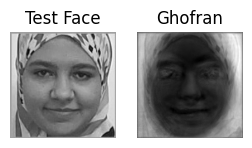

Minimum Distance :  34.998753757137955


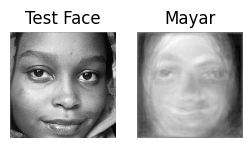

Minimum Distance :  48.088801657985705


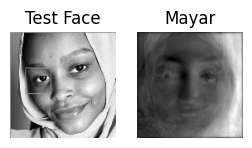

Minimum Distance :  37.084735662724896


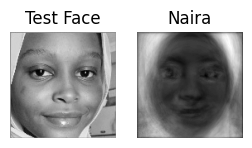

Minimum Distance :  35.28885960369307


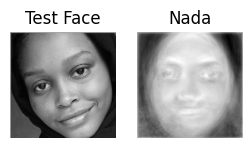

Minimum Distance :  38.52198847878521


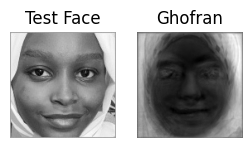

Minimum Distance :  47.71383709391624


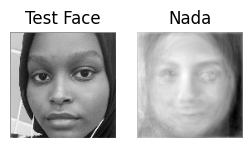

Minimum Distance :  28.764708835198963


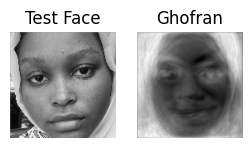

Minimum Distance :  32.39634215874685


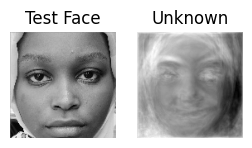

Minimum Distance :  42.724390993297945


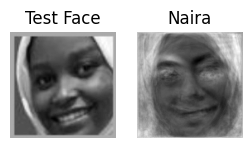

Minimum Distance :  37.12893788181582


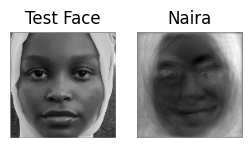

Minimum Distance :  0.014962178237724992


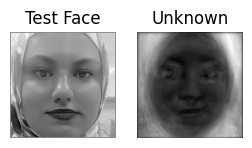

Minimum Distance :  0.008645716283949825


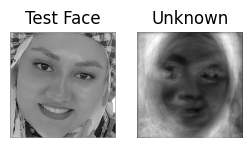

Minimum Distance :  0.03634259911431727


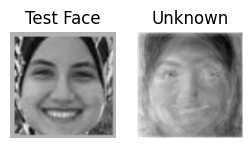

Minimum Distance :  0.05140802633564878


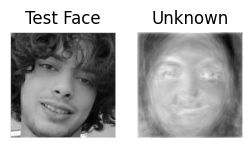

Minimum Distance :  0.07658218270027885


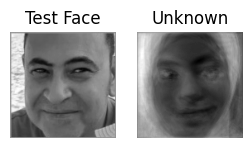

Minimum Distance :  41.04033731846955


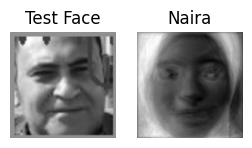

Minimum Distance :  0.3980876888853501


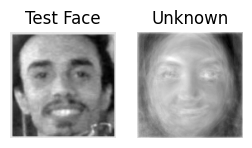

Minimum Distance :  0.013423990603242612


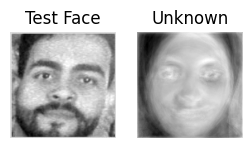

Minimum Distance :  0.044275843822685


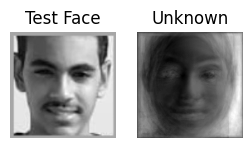

Minimum Distance :  0.0


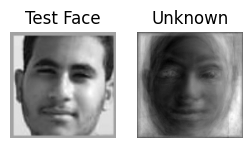

In [8]:

y_pred=[]
y_scors=[]

def Project(k, zero_mean_test, threshold):
    matrixU = np.zeros((16384, k))
    c = 0
    name = ""
    for val in range(k-1, -1, -1):
        matrixU[:, c] = u_list[val].flatten()
        c = c + 1
    w = np.dot(np.transpose(matrixU), np.transpose(zero_mean_test))
    original_w_k = dict[k]
    dist = []
    for wt_vectors in original_w_k:
        dist.append(np.linalg.norm(wt_vectors-w.T))

    # Step 1: Subtract the smallest distance from each distance in the group
    min_distance = min(dist)
    distances_shifted = [d - min_distance for d in dist]   
    # Step 2: Take the negative of each distance
    distances_neg = [-d for d in distances_shifted]
    # Step 3: Apply the softmax function to the negative distances
    probs = np.exp(distances_neg) / np.sum(np.exp(distances_neg))
    c1=np.mean(probs[0:30])          
    c2=np.mean(probs[30:60])
    c3=np.mean(probs[60:90])
    c4=np.mean(probs[90:120])
    c5=np.mean(probs[120:150])
    c6=np.mean(probs[150:])
    c1/=(c1+c2+c3+c4+c5+c6)
    c2/=(c1+c2+c3+c4+c5+c6)
    c3/=(c1+c2+c3+c4+c5+c6)
    c4/=(c1+c2+c3+c4+c5+c6)
    c5/=(c1+c2+c3+c4+c5+c6)
    c6/=(c1+c2+c3+c4+c5+c6)
    y_scors.append([c1,c2,c3,c4,c5,c6])

    print ("Minimum Distance : ",np.min(dist))
    nearest_face = np.argmin(dist)
    nearest_face_weights = original_w_k[nearest_face]
    zero_mean_test = zero_mean_test + np.transpose(Mean)
    face = np.dot(nearest_face_weights, np.transpose(matrixU))
    face = face + np.transpose(Mean)
    reshape_face = face.reshape(128, 128)
    if np.min(dist) < threshold:  
        index = nearest_face
        if index in range(0,30):
            name="Nada"
            y_pred.append(0)
        elif index in range(30,60):
            name="kareman"
            y_pred.append(1)
        elif index in range(60,90):
            name="Naira"
            y_pred.append(2)
        elif index in range(90,120):
            name="Mayar"
            y_pred.append(3)
        elif index in range(120,150):
            name="Ghofran" 
            y_pred.append(4)
        elif index in range(150,180):
            name="Unknown" 
            y_pred.append(5)
    else:
        index = -1
        name = 'Unknown'
        y_pred.append(5)
    return name, reshape_face
    
def runs(k):
    for num in range(TestImages_num):
        t = Testing_Images[num]
        test = t.flatten()
        zero_mean_test = test - np.transpose(Mean)
        name, face = Project(k, zero_mean_test, 80)  # threshold = 80
        fig1, axes_array = plt.subplots(1, 2)
        fig1.set_size_inches(3, 3)
        axes_array[0].imshow(t, cmap=plt.cm.gray)
        axes_array[0].axis('off')
        axes_array[0].set(title='Test Face')
        axes_array[1].imshow(face, cmap=plt.cm.gray)
        axes_array[1].axis('off')
        axes_array[1].set(title = name)
        plt.show()

print('\t\tk = 180')
runs(180)

In [9]:
y_test = []

for i in range(10):
    y_test.append(0)         #nada
for i in range(10):
    y_test.append(1)         #kareman 
for i in range(10):
    y_test.append(2)          #naira
for i in range(10):
    y_test.append(3)          #mayar
for i in range(10):
    y_test.append(4)          #ghofran 
for i in range(10):
    y_test.append(5)           #unknown
    
    

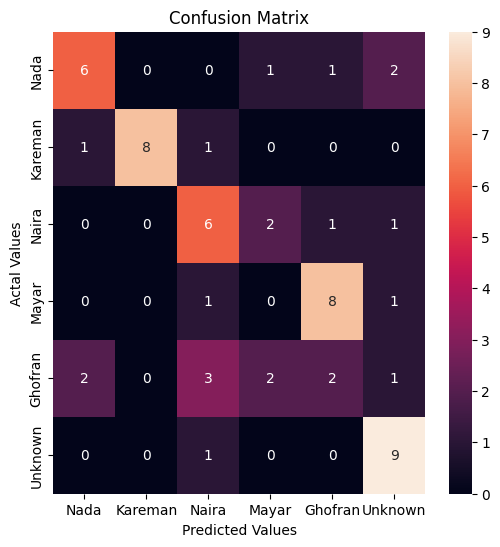

In [10]:

# Creating  a confusion matrix,which compares the y_test and y_pred
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm,
                     index = ['Nada','Kareman','Naira','Mayar','Ghofran','Unknown'], 
                     columns = ['Nada','Kareman','Naira','Mayar','Ghofran','Unknown'])
plt.figure(figsize=(6,6))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

Text(0.5, 1.0, 'Receiver operating characteristic for multi-class data')

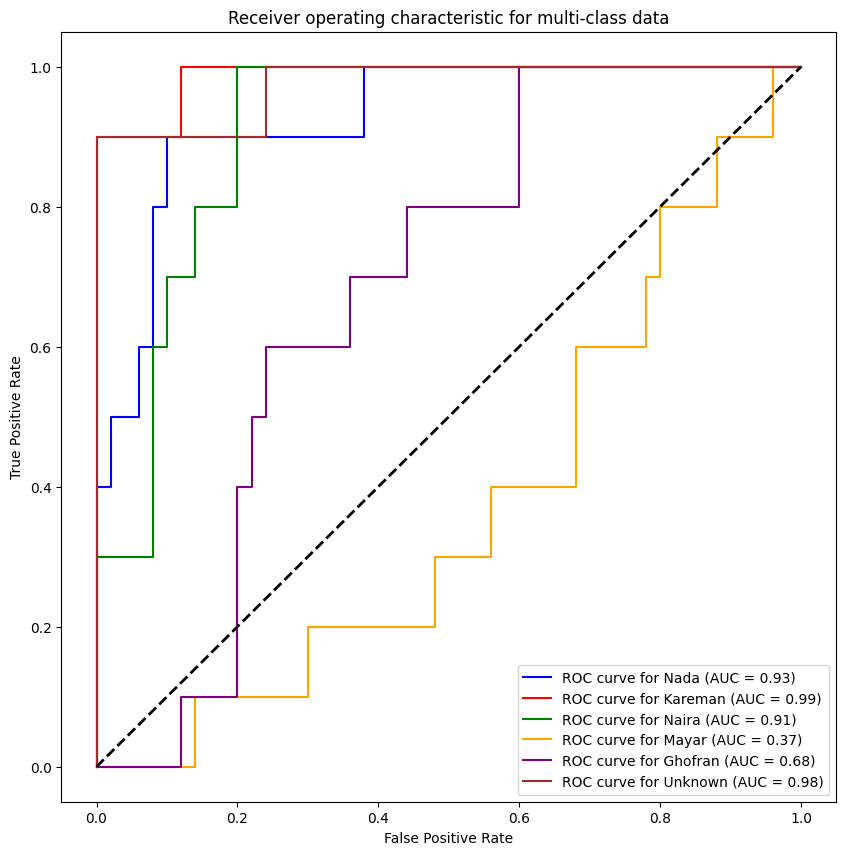

In [11]:

# Binarize the output
y_test = label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5])
y_probs=np.array(y_scors)
n_classes = y_test.shape[1]
target_names=['Nada','Kareman','Naira','Mayar','Ghofran','Unknown']
fpr = {}
tpr = {}
roc_auc ={}
lw=2
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink'])
fig, ax = plt.subplots(figsize=(10, 10))
for i, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        y_test[:, i],
        y_probs[:, i],
        name=f"ROC curve for {target_names[i]}", color=color,ax=ax)
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')